In [1]:
# 14.01.2025: code works, but I have to invert the sense of the distance
# since waves are travelling backwards now

# and then consequently I will have to change: 
# #start_time = 0  # Time in seconds starts at 0
#start_distance = cumulative_distances[-1]
#propagation_line_distance = start_distance + propagation_speed * time_seconds  # Distance = speed * time


# Data source from the model: /DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK

# Kind of data : filtered_sla_lat_-25.35_lon_157.95.nc

# Type of content: 

### Methodology for Phase Speed Estimation with Radon Transform

The phase speed of coastal trapped waves was computed using the Radon transform applied to Hovmöller diagrams. Below is an explanation of the process:

#### 1. **Preprocessing the Data**
- The Hovmöller diagram, which is a 2D matrix representing the temporal evolution of sea level anomalies (SLA) along the coastline, is normalized. This normalization step rescales the data to the range [0, 1] and removes the mean to center the data.

#### 2. **Radon Transform**
- The Radon transform is a mathematical tool used to project 2D data onto a set of lines defined by angles (θ). Each θ corresponds to a specific orientation, and the transform computes the integral of the data along the line for that angle.
- In the context of the Hovmöller diagram, the Radon transform identifies dominant linear features corresponding to propagating waves. These features indicate the angle θ that aligns with the direction of maximum variance in the data.

#### 3. **Finding the Optimal Angle (θ)**
- After applying the Radon transform, the sum of squared values is computed for each angle θ. This quantifies the energy or prominence of features aligned at each angle.
- The angle with the highest sum of squared values is considered the optimal angle (θ_opt), which corresponds to the dominant wave propagation direction.

#### 4. **Calculating Phase Speed**
- The slope of the wave propagation in the Hovmöller diagram is derived from the tangent of θ_opt:
  
  \[
  \tan(\theta_{\text{opt}}) = \frac{\Delta x}{\Delta t}
  \]
  
  Here, \( \Delta x \) is the spatial distance, and \( \Delta t \) is the temporal difference.
- The phase speed is calculated as the reciprocal of this slope:
  
  \[
  v_{\text{phase}} = \frac{1}{\tan(\theta_{\text{opt}})}
  \]

- If \( \tan(\theta_{\text{opt}}) \) is zero, the phase speed is infinite, indicating no propagation.

---

### 2D Correlation of Hovmöller Diagrams

#### Purpose
The goal of 2D correlation is to quantify the similarity between different Hovmöller diagrams, which represent data from various datasets (e.g., BLUELINK, SWOT, CMEMS).

#### Methodology

1. **Flattening the Hovmöller Diagrams**
   - Each Hovmöller diagram, originally a 2D matrix, is reshaped into a 1D array by concatenating all rows. This ensures compatibility with correlation calculations.

2. **Correlation Calculation**
   - The Pearson correlation coefficient is computed between the flattened arrays of two Hovmöller diagrams:

     \[
     r = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
     \]

     Where:
     - \( X \) and \( Y \) are the flattened arrays.
     - \( \text{Cov}(X, Y) \) is the covariance between \( X \) and \( Y \).
     - \( \sigma_X \) and \( \sigma_Y \) are the standard deviations of \( X \) and \( Y \), respectively.

   - The correlation coefficient \( r \) ranges from -1 to 1:
     - \( r = 1 \): Perfect positive correlation.
     - \( r = -1 \): Perfect negative correlation.
     - \( r = 0 \): No correlation.

3. **Pairwise Comparisons**
   - Correlations are calculated for all pairs of Hovmöller diagrams (e.g., BLUELINK vs SWOT, BLUELINK vs CMEMS, SWOT vs CMEMS).

#### Interpretation
- Higher correlation values indicate greater similarity in the temporal and spatial evolution of sea level anomalies across datasets.
- Lower values suggest discrepancies, which could be due to differences in the resolution, processing, or dynamics captured by each dataset.

---

### Visualization and Comparison

The Hovmöller diagrams for BLUELINK, SWOT, and CMEMS are displayed side by side in a single row of subplots for visual comparison. The phase speed and optimal angle (θ_opt) for each dataset are also overlaid on the diagrams as red dashed lines, illustrating the wave propagation.

The computed pairwise correlations provide a quantitative measure to complement the visual analysis, enabling a comprehensive evaluation of similarities and differences between the datasets.



/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Pairwise 2D Correlations between Hovmöller Diagrams:
CMEMS vs SWOT: 0.7421
CMEMS vs BLUELINK: 0.2721
SWOT vs BLUELINK: 0.4691


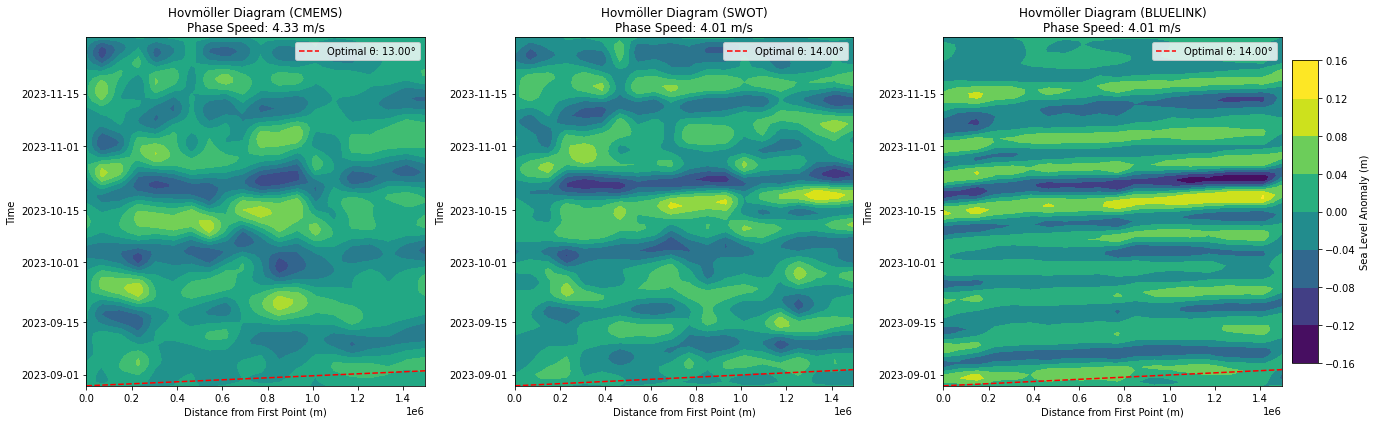

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
import xarray as xr
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import cKDTree
import cartopy.feature as cfeature
import os
import re
from geopy.distance import geodesic
from scipy.signal import find_peaks

def compute_cumulative_distance(points):
    """Compute cumulative distances from the first point."""
    cumulative_distances = [0]  # Distance from the first point to itself is 0
    for i in range(1, len(points)):
        dist = geodesic((points[i-1][1], points[i-1][0]), (points[i][1], points[i][0])).meters
        cumulative_distances.append(cumulative_distances[-1] + dist)
    return np.array(cumulative_distances)

def find_closest_file(directory, lat, lon):
    """Find the closest file in the directory based on latitude and longitude."""
    files = os.listdir(directory)
    closest_file = None
    closest_distance = float('inf')
    for file in files:
        match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
        if match:
            file_lat, file_lon = map(float, match.groups())
            distance = np.sqrt((lat - file_lat)**2 + (lon - file_lon)**2)
            if distance < closest_distance:
                closest_distance = distance
                closest_file = file
    return closest_file

# Step 1: Define the parallelogram
parallelogram_vertices = np.array([
    [149, -38],  # Bottom-left
    [158, -38],  # Bottom-right
    [158, -25],  # Top-right
    [149, -25]   # Top-left
])
parallelogram = Polygon(parallelogram_vertices)

# Step 2: Extract coastline using Cartopy
coastline = list(cfeature.COASTLINE.geometries())
coastline_points = []

for geometry in coastline:
    if geometry.intersects(parallelogram):
        if geometry.geom_type == 'LineString':
            coastline_points.extend(np.array(geometry.coords))
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                coastline_points.extend(np.array(line.coords))

coastline_points = np.array(coastline_points)

# Filter coastline points within the parallelogram
filtered_points = np.array([point for point in coastline_points if parallelogram.contains(Point(point))])

if len(filtered_points) > 1:
    first_point = filtered_points[0]
    last_point = filtered_points[-1]
    if last_point[1] < first_point[1] or last_point[0] < first_point[0]:
        filtered_points = filtered_points[::-1]

# Step 3: Interpolate Equally Spaced Points
coastline_line = LineString(filtered_points)
n_points = 20  # Define the number of equally spaced points
distances = np.linspace(0, coastline_line.length, n_points)
interpolated_points = np.array([coastline_line.interpolate(d).coords[0] for d in distances])

# Step 4: Compute Cumulative Distance
cumulative_distances = compute_cumulative_distance(interpolated_points)

# Step 5: Process datasets
# Reversing the order of data_labels for subplots to have CMEMS first, MIOST second, and BLUELINK third
base_dirs = [
    "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_CMEMS_DT2024",  # CMEMS first
    "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT",   # MIOST second (SWOT)
    "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK"  # BLUELINK third
]
data_labels = ["CMEMS", "SWOT", "BLUELINK"]
time_series_matrices = []
phase_speeds = []
optimal_thetas = []

for base_dir in base_dirs:
    grid_points = []
    files = os.listdir(base_dir)

    for file in files:
        match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
        if match:
            lat, lon = map(float, match.groups())
            grid_points.append((lon, lat))

    grid_points = np.array(grid_points)

    tree = cKDTree(grid_points)
    distances, indices = tree.query(interpolated_points)
    closest_points = grid_points[indices]

    time_series_list = []

    for i, index in enumerate(indices):
        lat, lon = grid_points[index][1], grid_points[index][0]
        closest_file = find_closest_file(base_dir, lat, lon)
        if closest_file:
            file_path = os.path.join(base_dir, closest_file)
            ds = xr.open_dataset(file_path)
            time_series = ds['filtered_sla'].values
            time_series_list.append(time_series)

    time_series_matrix = np.array(time_series_list)
    time_series_matrices.append(time_series_matrix)

    time = ds['time'].values

    # Normalize and preprocess the data
    data = time_series_matrix
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)
    data_scaled -= np.mean(data_scaled)

    # Apply the Radon transform
    theta = np.linspace(0, 180, 180, endpoint=False)
    radon_transform = radon(data_scaled, theta=theta, circle=False)

    # Compute the sum of squares for each angle
    sum_of_squares = np.sum(radon_transform**2, axis=0)

    # Find the angle θ with the maximum sum of squares
    optimal_theta = theta[np.argmax(sum_of_squares)]
    optimal_thetas.append(optimal_theta)

    # Calculate the propagation speed
    tan_theta = np.tan(np.deg2rad(optimal_theta))
    if tan_theta != 0:
        propagation_speed = 1 / tan_theta
    else:
        propagation_speed = np.inf

    phase_speeds.append(propagation_speed)

# Use the BLUELINK dataset for consistent color scaling
bluelink_data = time_series_matrices[2]
bluelink_min = np.min(bluelink_data)
bluelink_max = np.max(bluelink_data)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop to create plots for CMEMS, SWOT, and BLUELINK
for i, (matrix, label, speed, theta) in enumerate(zip(time_series_matrices, data_labels, phase_speeds, optimal_thetas)):
    ax = axes[i]
    contour = ax.contourf(cumulative_distances, time, matrix.T, cmap='viridis', vmin=bluelink_min, vmax=bluelink_max)
    ax.set_title(f"Hovmöller Diagram ({label})\nPhase Speed: {speed:.2f} m/s")
    ax.set_xlabel('Distance from First Point (m)')
    ax.set_ylabel('Time')

    # Ensure only positive values on the x-axis
    ax.set_xlim(left=0, right=cumulative_distances[-1])  # Set the minimum x-axis limit to 0

    # Overlay the straight line corresponding to the phase speed
    time_seconds = (time - time[0]) / np.timedelta64(1, 's')
    start_distance = cumulative_distances[0]
    propagation_line_distance = start_distance + speed * time_seconds
    ax.plot(propagation_line_distance, time, color='red', linestyle='--', label=f'Optimal θ: {theta:.2f}°')
    ax.legend()

# Create one shared colorbar for all the subplots
# This colorbar will span across the entire figure, reflecting the color limits of BLUELINK
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='vertical')
cbar.set_label('Sea Level Anomaly (m)')  # Same label for all

# Set the colorbar ticks to match the range of BLUELINK
#cbar.set_ticks(np.linspace(bluelink_min, bluelink_max, 5))

# Adjust layout to avoid overlapping and to accommodate the colorbar
plt.tight_layout()

# Save the figure to the specified path
output_path = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/plots_for_paper/hovmuller.jpg"
fig.savefig(output_path, bbox_inches='tight')

# Compute pairwise 2D correlations between datasets
correlations = np.zeros((len(time_series_matrices), len(time_series_matrices)))
for i in range(len(time_series_matrices)):
    for j in range(len(time_series_matrices)):
        flattened_i = time_series_matrices[i].flatten()
        flattened_j = time_series_matrices[j].flatten()
        correlation = np.corrcoef(flattened_i, flattened_j)[0, 1]
        correlations[i, j] = correlation

# Print pairwise correlations
print("Pairwise 2D Correlations between Hovmöller Diagrams:")
for i in range(len(data_labels)):
    for j in range(i + 1, len(data_labels)):
        print(f"{data_labels[i]} vs {data_labels[j]}: {correlations[i, j]:.4f}")

# Display the plot
plt.show()
